In [2]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333 and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)
len(recordings)

100%|██████████| 10557/10557 [01:05<00:00, 160.84it/s]


10391

In [ ]:
# Calculate the maximum length
max_length = max(length_list)

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape


# for i in adjusted_recordings:
#     print(i.shape)

In [4]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

# Pre-process data

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


############################################################################################################
standard = StandardScaler()
adjusted_recordings = standard.fit_transform(adjusted_recordings)
print(adjusted_recordings)

############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and testing sets
X_train, X_test_help, y_train, y_test_help = train_test_split(adjusted_recordings, valence_values, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test_help, y_test_help, test_size=0.5, random_state=42)



############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

############################################################################################################
# Repeat the same process for the test set

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




[[-3.91315894e-03 -2.08178719e-03  7.07403015e-03 ...  3.97710492e-02
   3.89222529e-02  3.43722279e-02]
 [ 2.54340067e-01  3.18888249e-01  5.00963191e-01 ... -3.15180136e-01
  -2.67018609e-01 -1.80737937e-01]
 [-1.11767359e-03 -2.09454250e-03 -2.72278684e-04 ...  1.59298169e-02
   9.39241865e-03 -2.23828698e-03]
 ...
 [ 2.27792832e-01  2.35611148e-01  2.11838498e-01 ...  6.82101747e-02
   5.28060648e-02  1.46057692e-02]
 [-3.71829769e-03 -1.78789066e-03 -1.21324795e-03 ...  8.64892466e-02
  -1.11829173e-01 -1.93425859e-01]
 [-2.01032000e-01 -3.58533093e-01 -1.35592739e-01 ... -3.44990583e+00
  -3.14912292e+00 -2.65295907e+00]]


In [6]:
train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape

(torch.Size([6234, 1, 90948]), torch.Size([6234]))

In [22]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()



        # Set random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=44100,      ## 44.1 kHz
            n_mfcc=24              ## Created channels
        )

        self.layers = nn.ModuleList()
        
        self.layers.append(nn.BatchNorm1d(24))
        conv1 = nn.Conv1d(in_channels=24, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))

        conv2 = nn.Conv1d(in_channels=48, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())


        conv3 = nn.Conv1d(in_channels=48, out_channels=12, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(12))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))


        self.layers.append(nn.Flatten())

        linear1= nn.Linear(564,256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)


    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs):
        criterion = nn.MSELoss()
        #criterion = nn.L1Loss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass

                optimizer.step()

                # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
                total_loss += loss.item()
        
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                print(evaluate_model(MLP_model, validation_loader,conf=False))
            print('--------------------------------------------------')
        print(evaluate_model(MLP_model, train_loader,conf=True))


def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():
        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')
            
        

        


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:03<02:57,  3.62s/it]

Epoch [1/50], Loss: 1.8833
--------------------------------------------------


  4%|▍         | 2/50 [00:06<02:41,  3.36s/it]

Epoch [2/50], Loss: 0.8410
--------------------------------------------------
Epoch [3/50], Loss: 0.7015


  6%|▌         | 3/50 [00:10<02:54,  3.71s/it]

Mean Squared Error: 0.7468 and Mean Absolute Error: 0.6870
None
--------------------------------------------------
Epoch [4/50], Loss: 0.6626


  8%|▊         | 4/50 [00:15<03:00,  3.92s/it]

Mean Squared Error: 0.6794 and Mean Absolute Error: 0.6775
None
--------------------------------------------------
Epoch [5/50], Loss: 0.6250


 10%|█         | 5/50 [00:20<03:12,  4.27s/it]

Mean Squared Error: 0.6614 and Mean Absolute Error: 0.6490
None
--------------------------------------------------
Epoch [6/50], Loss: 0.5877


 12%|█▏        | 6/50 [00:25<03:25,  4.68s/it]

Mean Squared Error: 0.6196 and Mean Absolute Error: 0.6450
None
--------------------------------------------------
Epoch [7/50], Loss: 0.5572


 14%|█▍        | 7/50 [00:30<03:23,  4.74s/it]

Mean Squared Error: 0.6080 and Mean Absolute Error: 0.6287
None
--------------------------------------------------
Epoch [8/50], Loss: 0.5396


 16%|█▌        | 8/50 [00:34<03:16,  4.67s/it]

Mean Squared Error: 0.5776 and Mean Absolute Error: 0.6203
None
--------------------------------------------------
Epoch [9/50], Loss: 0.5395


 18%|█▊        | 9/50 [00:38<03:03,  4.47s/it]

Mean Squared Error: 0.5568 and Mean Absolute Error: 0.6057
None
--------------------------------------------------
Epoch [10/50], Loss: 0.5228


 20%|██        | 10/50 [00:42<02:49,  4.25s/it]

Mean Squared Error: 0.5674 and Mean Absolute Error: 0.6089
None
--------------------------------------------------
Epoch [11/50], Loss: 0.5161


 22%|██▏       | 11/50 [00:46<02:36,  4.00s/it]

Mean Squared Error: 0.5532 and Mean Absolute Error: 0.6077
None
--------------------------------------------------
Epoch [12/50], Loss: 0.5080


 24%|██▍       | 12/50 [00:49<02:25,  3.82s/it]

Mean Squared Error: 0.5390 and Mean Absolute Error: 0.5963
None
--------------------------------------------------
Epoch [13/50], Loss: 0.4989


 26%|██▌       | 13/50 [00:52<02:17,  3.71s/it]

Mean Squared Error: 0.5404 and Mean Absolute Error: 0.5925
None
--------------------------------------------------
Epoch [14/50], Loss: 0.4753


 28%|██▊       | 14/50 [00:56<02:10,  3.63s/it]

Mean Squared Error: 0.5339 and Mean Absolute Error: 0.5950
None
--------------------------------------------------
Epoch [15/50], Loss: 0.4799


 30%|███       | 15/50 [01:00<02:08,  3.68s/it]

Mean Squared Error: 0.5242 and Mean Absolute Error: 0.5845
None
--------------------------------------------------
Epoch [16/50], Loss: 0.4813


 32%|███▏      | 16/50 [01:04<02:06,  3.72s/it]

Mean Squared Error: 0.5283 and Mean Absolute Error: 0.5900
None
--------------------------------------------------
Epoch [17/50], Loss: 0.4663


 34%|███▍      | 17/50 [01:07<02:03,  3.74s/it]

Mean Squared Error: 0.5203 and Mean Absolute Error: 0.5849
None
--------------------------------------------------
Epoch [18/50], Loss: 0.4720


 36%|███▌      | 18/50 [01:11<02:00,  3.77s/it]

Mean Squared Error: 0.5199 and Mean Absolute Error: 0.5862
None
--------------------------------------------------
Epoch [19/50], Loss: 0.4663


 38%|███▊      | 19/50 [01:15<01:56,  3.75s/it]

Mean Squared Error: 0.5260 and Mean Absolute Error: 0.5902
None
--------------------------------------------------
Epoch [20/50], Loss: 0.4614


 40%|████      | 20/50 [01:19<01:52,  3.77s/it]

Mean Squared Error: 0.5073 and Mean Absolute Error: 0.5789
None
--------------------------------------------------
Epoch [21/50], Loss: 0.4576


 42%|████▏     | 21/50 [01:22<01:48,  3.76s/it]

Mean Squared Error: 0.5038 and Mean Absolute Error: 0.5791
None
--------------------------------------------------
Epoch [22/50], Loss: 0.4553


 44%|████▍     | 22/50 [01:27<01:48,  3.89s/it]

Mean Squared Error: 0.5029 and Mean Absolute Error: 0.5801
None
--------------------------------------------------
Epoch [23/50], Loss: 0.4466


 46%|████▌     | 23/50 [01:31<01:46,  3.93s/it]

Mean Squared Error: 0.5083 and Mean Absolute Error: 0.5795
None
--------------------------------------------------
Epoch [24/50], Loss: 0.4535


 48%|████▊     | 24/50 [01:34<01:40,  3.87s/it]

Mean Squared Error: 0.5086 and Mean Absolute Error: 0.5816
None
--------------------------------------------------
Epoch [25/50], Loss: 0.4391


 50%|█████     | 25/50 [01:38<01:36,  3.86s/it]

Mean Squared Error: 0.5031 and Mean Absolute Error: 0.5763
None
--------------------------------------------------
Epoch [26/50], Loss: 0.4370


 52%|█████▏    | 26/50 [01:42<01:31,  3.82s/it]

Mean Squared Error: 0.5060 and Mean Absolute Error: 0.5813
None
--------------------------------------------------
Epoch [27/50], Loss: 0.4400


 54%|█████▍    | 27/50 [01:46<01:27,  3.83s/it]

Mean Squared Error: 0.5107 and Mean Absolute Error: 0.5798
None
--------------------------------------------------
Epoch [28/50], Loss: 0.4332


 56%|█████▌    | 28/50 [01:50<01:24,  3.83s/it]

Mean Squared Error: 0.4983 and Mean Absolute Error: 0.5760
None
--------------------------------------------------
Epoch [29/50], Loss: 0.4342


 58%|█████▊    | 29/50 [01:53<01:20,  3.83s/it]

Mean Squared Error: 0.4968 and Mean Absolute Error: 0.5766
None
--------------------------------------------------
Epoch [30/50], Loss: 0.4230


 60%|██████    | 30/50 [01:57<01:15,  3.78s/it]

Mean Squared Error: 0.5028 and Mean Absolute Error: 0.5733
None
--------------------------------------------------
Epoch [31/50], Loss: 0.4260


 62%|██████▏   | 31/50 [02:01<01:13,  3.87s/it]

Mean Squared Error: 0.4873 and Mean Absolute Error: 0.5707
None
--------------------------------------------------
Epoch [32/50], Loss: 0.4203


 64%|██████▍   | 32/50 [02:05<01:11,  3.98s/it]

Mean Squared Error: 0.4928 and Mean Absolute Error: 0.5725
None
--------------------------------------------------
Epoch [33/50], Loss: 0.4164


 66%|██████▌   | 33/50 [02:09<01:06,  3.93s/it]

Mean Squared Error: 0.4999 and Mean Absolute Error: 0.5746
None
--------------------------------------------------
Epoch [34/50], Loss: 0.4171


 68%|██████▊   | 34/50 [02:13<01:02,  3.89s/it]

Mean Squared Error: 0.4978 and Mean Absolute Error: 0.5743
None
--------------------------------------------------
Epoch [35/50], Loss: 0.4169


 70%|███████   | 35/50 [02:17<00:57,  3.84s/it]

Mean Squared Error: 0.4860 and Mean Absolute Error: 0.5677
None
--------------------------------------------------
Epoch [36/50], Loss: 0.4145


 72%|███████▏  | 36/50 [02:21<00:53,  3.85s/it]

Mean Squared Error: 0.4781 and Mean Absolute Error: 0.5658
None
--------------------------------------------------
Epoch [37/50], Loss: 0.4107


 74%|███████▍  | 37/50 [02:24<00:49,  3.83s/it]

Mean Squared Error: 0.4912 and Mean Absolute Error: 0.5677
None
--------------------------------------------------
Epoch [38/50], Loss: 0.4112


 76%|███████▌  | 38/50 [02:28<00:45,  3.79s/it]

Mean Squared Error: 0.4958 and Mean Absolute Error: 0.5709
None
--------------------------------------------------
Epoch [39/50], Loss: 0.4046


 78%|███████▊  | 39/50 [02:32<00:41,  3.82s/it]

Mean Squared Error: 0.4867 and Mean Absolute Error: 0.5657
None
--------------------------------------------------
Epoch [40/50], Loss: 0.4080


 80%|████████  | 40/50 [02:36<00:37,  3.79s/it]

Mean Squared Error: 0.4810 and Mean Absolute Error: 0.5652
None
--------------------------------------------------
Epoch [41/50], Loss: 0.4010


 82%|████████▏ | 41/50 [02:39<00:33,  3.76s/it]

Mean Squared Error: 0.4956 and Mean Absolute Error: 0.5750
None
--------------------------------------------------
Epoch [42/50], Loss: 0.4109


 84%|████████▍ | 42/50 [02:43<00:30,  3.78s/it]

Mean Squared Error: 0.4941 and Mean Absolute Error: 0.5664
None
--------------------------------------------------
Epoch [43/50], Loss: 0.3963


 86%|████████▌ | 43/50 [02:47<00:27,  3.88s/it]

Mean Squared Error: 0.4767 and Mean Absolute Error: 0.5599
None
--------------------------------------------------
Epoch [44/50], Loss: 0.4031


 88%|████████▊ | 44/50 [02:51<00:23,  3.96s/it]

Mean Squared Error: 0.4862 and Mean Absolute Error: 0.5653
None
--------------------------------------------------
Epoch [45/50], Loss: 0.3982


 90%|█████████ | 45/50 [02:55<00:19,  3.92s/it]

Mean Squared Error: 0.4977 and Mean Absolute Error: 0.5715
None
--------------------------------------------------
Epoch [46/50], Loss: 0.3958


 92%|█████████▏| 46/50 [02:59<00:15,  3.87s/it]

Mean Squared Error: 0.4839 and Mean Absolute Error: 0.5669
None
--------------------------------------------------
Epoch [47/50], Loss: 0.3932


 94%|█████████▍| 47/50 [03:03<00:11,  3.89s/it]

Mean Squared Error: 0.4832 and Mean Absolute Error: 0.5703
None
--------------------------------------------------
Epoch [48/50], Loss: 0.3881


 96%|█████████▌| 48/50 [03:07<00:07,  3.86s/it]

Mean Squared Error: 0.4794 and Mean Absolute Error: 0.5647
None
--------------------------------------------------
Epoch [49/50], Loss: 0.3848


 98%|█████████▊| 49/50 [03:11<00:03,  3.85s/it]

Mean Squared Error: 0.4863 and Mean Absolute Error: 0.5650
None
--------------------------------------------------
Epoch [50/50], Loss: 0.3827


100%|██████████| 50/50 [03:14<00:00,  3.90s/it]

Mean Squared Error: 0.4774 and Mean Absolute Error: 0.5622
None
--------------------------------------------------


Mean Squared Error: 0.3807 and Mean Absolute Error: 0.4971


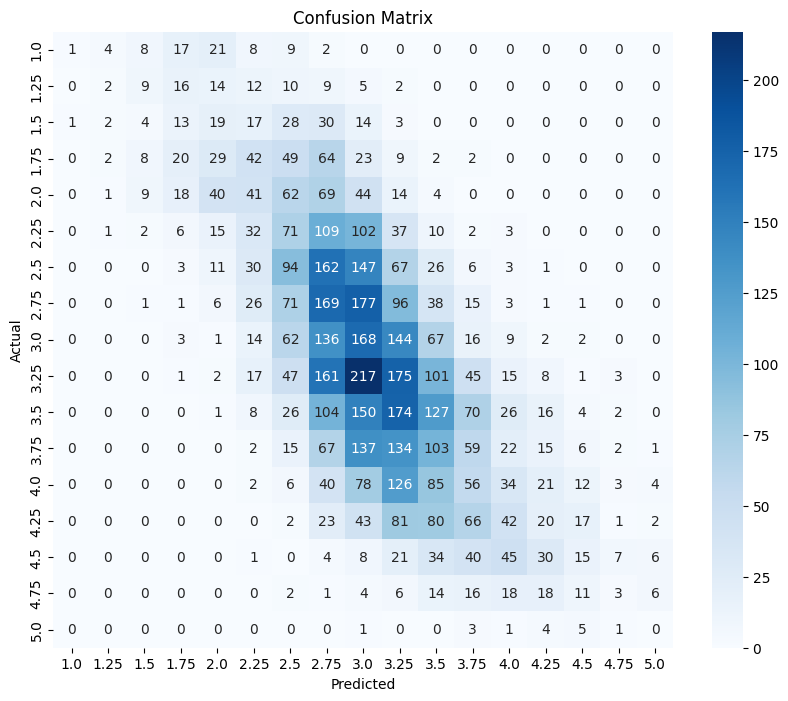

Accuracy: 0.1545
None


In [23]:
modelCNN = CNN().to(device)
optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.Adadelta(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#lr = 0.001
train_model(modelCNN, optimizer, num_epochs=50)

Mean Squared Error: 0.4633 and Mean Absolute Error: 0.5504


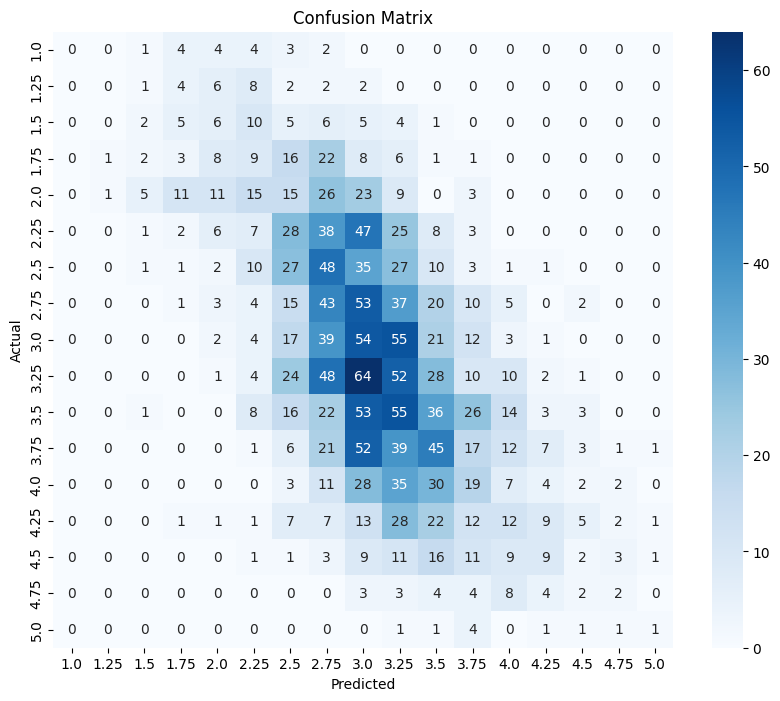

Accuracy: 0.1313


In [24]:
evaluate_model(modelCNN, test_loader,conf=True)

Mean Squared Error: 0.3836 and Mean Absolute Error: 0.5005


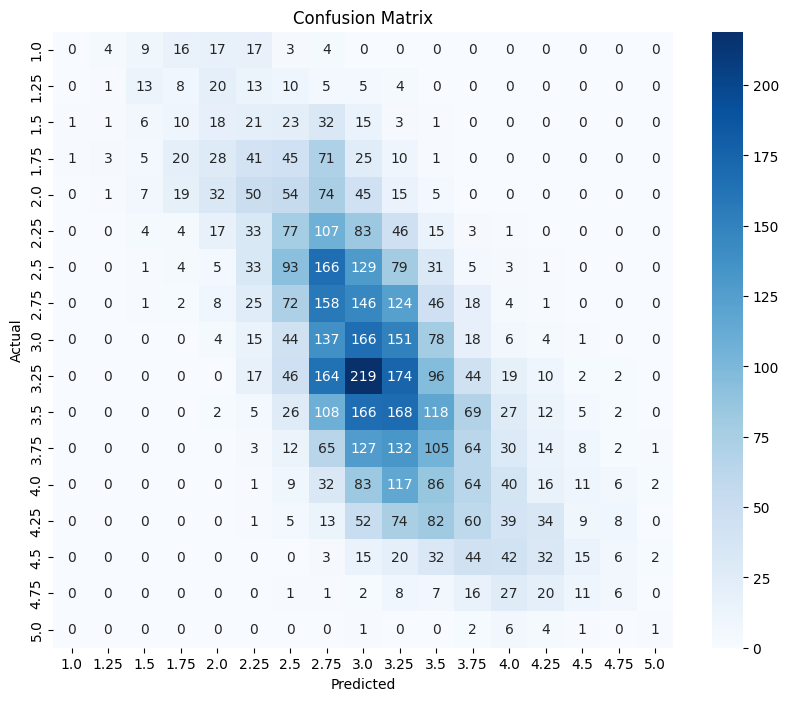

Accuracy: 0.1542


In [25]:
evaluate_model(modelCNN, train_loader,conf=True)